In [28]:
%load_ext autoreload
%autoreload 2

In [17]:
import pandas as pd 
import numpy as np
from itertools import product, permutations

import numba
from numba import njit,vectorize, jit
from tqdm import tqdm

import Estimators
import Unsupervised

In [3]:
d = 2
c = 0

In [4]:
#@njit
sig2 = 1
@njit
def GaussianKernel(x,y):
    return np.exp(-np.linalg.norm(x-y)**2/(2*sig2))

@njit
def PolynomialKernel(x,y): 
    return (x.dot(y)+c)**d
@njit
def LinearKernel(x,y): 
    return x.dot(y)

@njit
def Laplace_kernel(x, y, gamma=1):
    return 0.5 * np.exp(-gamma * np.linalg.norm(x-y))

In [5]:
def importation_mat_100(): 
    '''
    import all the (float) data and puts them in a list X_train_100. X_train_100[0] will be X_train_mat_100 and so on. 
    '''
    X_train_100 = []
    X_test_100 = []
    Y_train = []
    for i in range(3): 
        xtrain = pd.read_csv('data/Xtr'+str(i)+'_mat100.csv',delimiter= ',', header= None)
        xtrain = np.squeeze(xtrain.to_numpy())
        X_train_100.append(xtrain)
    
        xtest = pd.read_csv('data/Xte'+str(i)+'_mat100.csv',delimiter= ',', header= None)
        xtest = np.squeeze(xtest.to_numpy())
        X_test_100.append(xtest)
    
        Y_train.append(pd.read_csv('data/Ytr'+str(i)+'.csv',delimiter= ',')['Bound'].to_numpy())
    return X_train_100,X_test_100,Y_train

def importation(): 
    '''
    import all the (string) data and puts them in a list X_train. X_train[0] will be X_train_0 and so on. 
    '''
    X_train = []
    X_test = []
    Y_train = []
    for i in range(3): 
        xtrain = pd.read_csv('data/Xtr'+str(i)+'.csv',delimiter= ',', header= None)
        xtrain = xtrain.iloc[1:,1].to_numpy()
        X_train.append(xtrain)
    
        xtest = pd.read_csv('data/Xte'+str(i)+'.csv',delimiter= ',', header= None)
        xtest = xtest.iloc[1:,1].to_numpy()
        X_test.append(xtest)
    
        Y_train.append(pd.read_csv('data/Ytr'+str(i)+'.csv',delimiter= ',')['Bound'].to_numpy())
    return X_train,X_test,Y_train

X_train,X_test,Y_train = importation()
X_train_100, X_test_100,Y_train = importation_mat_100()

In [6]:
'''
we do this so that we compute the Dictionnary of phi_spectrum easier. 
'''

X_traintest = []
for i in range(3): 
    X_traintest.append(np.concatenate((X_train[i],X_test[i])))


In [7]:
def to_Kernel_train(X, Kernel): 
    length = X.shape[0]
    mat_K = np.zeros((length,length))
    for i in range(length):
        x_i = np.squeeze(X[i])
        for j in range(i,length): 
            x_j = np.squeeze(X[j])
            value = Kernel(x_i,x_j)
            mat_K[i,j] = value
            mat_K[j,i] = value 
    return mat_K

#@njit 
def to_Kernel_test(Xtrain,Xtest,Kernel):
    '''
    takes the training data input Xtrain and the test data Xtest and computes the Kernel_test. 
    
    The length of the resulting Kernel_test will be (nb_traing_samples, nb_testing_samples) 
    '''
    length_train = Xtrain.shape[0]
    length_test = Xtest.shape[0]
    bimat_K = np.zeros((length_train,length_test))
    for i in range(length_train):
        x_i = np.squeeze(Xtrain[i])
        for j in range(length_test): 
            x_j = np.squeeze(Xtest[j])
            bimat_K[i,j] = Kernel(x_i,x_j)
    return bimat_K

def standardize(K): 
    '''
    standardize the given matrix K
    '''
    U = np.full(K.shape,1/K.shape[0])
    I = np.eye(K.shape[0])
    return (I-U)@K@(I-U)

In [8]:
# Compute phi for Spectrum kernel
def phi_spectrum(x,k,U):
    """U: list of the sequences of size k to look for in x"""
    phi_spec = np.zeros(len(U))
    for j, u in enumerate(U):
        for i in range(len(x)-k+1):
            if x[i:i+k] == u:
                phi_spec[j] +=1
    return phi_spec

#Compute phi for Substring kernel
def l(i):
    return i[-1] - i[0] + 1

def I(k,n):
    I = set()
    for ele in permutations(range(0,n),k):
        I.add(tuple(sorted(list(ele))))
    return list(I)

def phi_substring(x,k,U,lamb=0.5): #fonctionne (testé avec l'exemple page 392)
    """U: list of the sequences of size k to look for in x"""
    phi = np.zeros(len(U))
    I_kn = I(k,len(x))
    for j, u in enumerate(U):
        for i in I_kn:
            x_i = "".join([x[idx]  for idx in i])
            if x_i==u:
                phi[j] += lamb**l(i)
    return phi


def make_dict_phi(X, phi,k):
    U = [''.join(letter) for letter in product('ACGT', repeat=k)]
    phi_dict = {seq:phi(seq,k,U) for seq in tqdm(X)}
    return phi_dict


In [10]:
##CONSTRUCTION DES DICTIONNAIRES. On fait ça pour eviter de les recalculer à chaque fois
## just uncomment the ones you want to compute. (and uncomment the next line also). for k=8, takes about 2 hours. 
dict_spectrum_traintest = [0]*10

#dict_spectrum_traintest[3] = make_dict_phi(X_traintest[0],phi_spectrum,3)
#dict_spectrum_traintest[4] = make_dict_phi(X_traintest[0],phi_spectrum,4)

#dict_spectrum_traintest[5] = make_dict_phi(np.concatenate(X_traintest),phi_spectrum,5)
dict_spectrum_traintest[6] = make_dict_phi(np.concatenate(X_traintest),phi_spectrum,6)
#dict_spectrum_traintest[7] = make_dict_phi(np.concatenate(X_traintest),phi_spectrum,7)
#dict_spectrum_traintest[8] = make_dict_phi(np.concatenate(X_traintest),phi_spectrum,8)
#dict_sub_traintest_2 = make_dict_phi(X_traintest[0], phi_substring,2)

#dict_sub_traintest_3 = make_dict_phi(X_traintest[0], phi_substring,3)

100%|██████████| 9000/9000 [06:31<00:00, 22.96it/s]


In [14]:
def make_K_spectrum(k): 
    '''
    template function to build a K_spectrum_function. 
    We need to have one function for each kernel functionin order to compute efficiently the Kernel matrix (it makes code fluent). 
    '''
    def K_spectrum(x,y): 
        value = np.sum([dict_spectrum_traintest[k][str(x)] * dict_spectrum_traintest[k][str(y)]])
        return value 
    return K_spectrum
K_spectrum_5 = make_K_spectrum(5)
K_spectrum_6 = make_K_spectrum(6)
K_spectrum_7 = make_K_spectrum(7)

In [85]:
dict_spectrum_traintest[5][X_train[0][1]]

array([0., 0., 0., ..., 0., 2., 3.])

In [15]:
def get_first_Kernels(Kernel): 
    '''
    gets the first Kernel_train and Kernel_test. This is only for testing one model one the first dataset. 
    '''
    K_train = to_Kernel_train(X_train[0], Kernel)
    K_test = to_Kernel_test(X_train[0], X_test[0], Kernel)
    return K_train,K_test 

def get_list_Kernels_100(Kernel) : 
    '''
    get two list ok Kernel. For list_K_train, each element i is the Kernel_train computed with kernel for dataset i. Same for list_K_test
    args : 
        
        Kernel : a Kernel function, for example K_sprectum_6
        
    returns : 
    
            List_Kernel_train : a list where each element i is the Kernel_train computed with Kernel for dataset i.
            
            List_Kernel_test : a list where each element i is the Kernel_test computed with Kernel for dataset i. 
            
    Only works for Kernel that takes as input floats, for example GaussianKernel
    '''
    list_K_train = list()
    list_K_test = list()
    for i in tqdm(range(3)): 
        list_K_train.append(to_Kernel_train(X_train_100[i], Kernel))
        list_K_test.append(to_Kernel_test(X_train_100[i],X_test_100[i], Kernel))
    return list_K_train,list_K_test

def get_list_Kernels(Kernel) : 
    '''
    
    get two list ok Kernel. For list_K_train, each element i is the Kernel_train computed with kernel for dataset i. Same for list_K_test
    args : 
        
        Kernel : a Kernel function, for example K_sprectum_6
        
    returns : 
    
            List_Kernel_train : a list where each element i is the Kernel_train computed with Kernel for dataset i.
            
            List_Kernel_test : a list where each element i is the Kernel_test computed with Kernel for dataset i. 
            
    Only works for Kernel that takes as input strings, for example K_spectrum. 
    
    '''
    list_K_train = list()
    list_K_test = list()
    for i in tqdm(range(3)): 
        list_K_train.append(to_Kernel_train(X_train[i], Kernel))
        list_K_test.append(to_Kernel_test(X_train[i],X_test[i], Kernel))
    return list_K_train,list_K_test

In [16]:
list_K_train_spectrum_6, list_K_test_spectrum_6 = get_list_Kernels(K_spectrum_6)  

100%|██████████| 3/3 [05:18<00:00, 106.16s/it]


In [95]:
list_K_train_spectrum_5, list_K_test_spectrum_5 = get_list_Kernels(K_spectrum_5)  

100%|██████████| 3/3 [05:21<00:00, 107.27s/it]


In [18]:
list_K_train_spectrum_7, list_K_test_spectrum_7 = get_list_Kernels(K_spectrum_7)  

100%|██████████| 3/3 [09:34<00:00, 191.66s/it]


In [160]:
def grid_search_cv(model, Kernel_train, Y_train, parameters): 
    '''
    grid search cv. 
    put the model you want, for example Estimators.KRR(), the Kernel_train you want to train on, the labels Y_train
    and the list of parameters (parameters) you want to try. 
    
    Will print the best parameter with the score associated. 
    '''
    scores = list()
    for parameter in parameters : 
        model.set_parameter(parameter)
        scores.append(model.cross_val(Kernel_train,Y_train, 5))
        print('We have tested  : ', np.round(parameter, 6))
    arg_max = np.argmax(np.array(scores))
    print('###########BEST_PARAM = ',np.round(parameters[arg_max], 6), 'with score :', scores[arg_max])
    return parameters[arg_max]

In [161]:
KRR_spectrum_7 = Estimators.KRR(Kernel = K_spectrum_7)
parameters = np.linspace(0.0001,0.2,30)
#parameters = 10**np.linspace(-10,0,15)
grid_search_cv(KRR_spectrum_7, list_K_train_spectrum_7[2], Y_train[2], parameters)

5it [00:00,  9.12it/s]
0it [00:00, ?it/s]

Score :  0.7105
We have tested  :  0.0001


5it [00:00, 11.08it/s]
0it [00:00, ?it/s]

Score :  0.716
We have tested  :  0.006993


5it [00:00,  7.06it/s]
0it [00:00, ?it/s]

Score :  0.7275
We have tested  :  0.013886


5it [00:00, 10.51it/s]
0it [00:00, ?it/s]

Score :  0.7295
We have tested  :  0.020779


5it [00:00, 12.44it/s]
0it [00:00, ?it/s]

Score :  0.736
We have tested  :  0.027672


5it [00:00, 11.48it/s]
0it [00:00, ?it/s]

Score :  0.7355
We have tested  :  0.034566


5it [00:00, 12.59it/s]
0it [00:00, ?it/s]

Score :  0.7344999999999999
We have tested  :  0.041459


5it [00:00, 12.18it/s]


Score :  0.739
We have tested  :  0.048352


5it [00:00,  9.83it/s]
0it [00:00, ?it/s]

Score :  0.7384999999999999
We have tested  :  0.055245


5it [00:00, 10.48it/s]
0it [00:00, ?it/s]

Score :  0.7344999999999999
We have tested  :  0.062138


5it [00:00, 11.03it/s]
0it [00:00, ?it/s]

Score :  0.7404999999999999
We have tested  :  0.069031


5it [00:00, 11.48it/s]
0it [00:00, ?it/s]

Score :  0.731
We have tested  :  0.075924


5it [00:00, 12.60it/s]
0it [00:00, ?it/s]

Score :  0.74
We have tested  :  0.082817


5it [00:00,  9.65it/s]
0it [00:00, ?it/s]

Score :  0.7295
We have tested  :  0.08971


5it [00:00, 11.20it/s]
0it [00:00, ?it/s]

Score :  0.7415
We have tested  :  0.096603


5it [00:00,  9.04it/s]
0it [00:00, ?it/s]

Score :  0.739
We have tested  :  0.103497


5it [00:00, 14.37it/s]
0it [00:00, ?it/s]

Score :  0.731
We have tested  :  0.11039


5it [00:00, 11.29it/s]
0it [00:00, ?it/s]

Score :  0.736
We have tested  :  0.117283


5it [00:00, 10.89it/s]
0it [00:00, ?it/s]

Score :  0.7335
We have tested  :  0.124176


5it [00:00, 12.34it/s]
0it [00:00, ?it/s]

Score :  0.7255
We have tested  :  0.131069


5it [00:00, 13.01it/s]
0it [00:00, ?it/s]

Score :  0.7344999999999999
We have tested  :  0.137962


5it [00:00, 11.88it/s]
0it [00:00, ?it/s]

Score :  0.743
We have tested  :  0.144855


5it [00:00, 12.66it/s]
0it [00:00, ?it/s]

Score :  0.729
We have tested  :  0.151748


5it [00:00,  9.20it/s]
0it [00:00, ?it/s]

Score :  0.7344999999999999
We have tested  :  0.158641


5it [00:00, 13.49it/s]
0it [00:00, ?it/s]

Score :  0.7304999999999999
We have tested  :  0.165534


5it [00:00, 11.87it/s]
0it [00:00, ?it/s]

Score :  0.7255
We have tested  :  0.172428


5it [00:00, 13.96it/s]
0it [00:00, ?it/s]

Score :  0.7364999999999999
We have tested  :  0.179321


5it [00:00, 13.90it/s]
0it [00:00, ?it/s]

Score :  0.7315
We have tested  :  0.186214


5it [00:00, 12.79it/s]
0it [00:00, ?it/s]

Score :  0.7264999999999999
We have tested  :  0.193107


5it [00:00, 13.61it/s]

Score :  0.734
We have tested  :  0.2
###########BEST_PARAM =  0.144855 with score : 0.743


0.14485517241379312

In [38]:
def download_results(model,list_Kernel_train,list_Kernel_test, parameters, name_dossier):
    '''
    Download the predictions of the 3 datasets, where the model will be trained with the Kernel_train you give and the parameter you give. 
    
    args : 
            model : a model for example Estimators.KRR()
            list_Kernel_train : a list where the element i is the Kernel_train of the i dataset (not any Kernel_train, the one computed with the Kernel of your choice)
            list_Kernel_test : a list where the element i is the Kernel_test of the i dataset (not any Kernel_test, the one computed with the Kernel of your choice)
            parameters : a list of parameters you want to try. 
            name_dossier : your predictions will be stocked in the dossier 'predictions_KM'+name_dossier+'.csv'
            
    returns : None. 
    
    All your predictions will be directly saved. 
    '''
    
    Y_predicted = []
    for i in range(3): 
        model.set_parameter(parameters[i])
        model.fit(list_Kernel_train[i], Y_train[i])
        Y_predicted.append(model.predict(list_Kernel_test[i])*1)
        print('Model {} Predicted'.format(i))

    d = { 'Id' : np.arange(3000), 'Bound' : np.concatenate(Y_predicted)}
    out = pd.DataFrame(data=d)
    out.to_csv('predictions_KM'+name_dossier+'.csv', index=False)

In [40]:
best_parameters = [0.2057,1.1275,0.06903]
download_results(KRR_spectrum_7,list_K_train_spectrum_7,list_K_test_spectrum_7,best_parameters,'K_spectrum_7')

Model 0 Predicted
Model 1 Predicted
Model 2 Predicted


In [154]:
def downloads_from_voting(models, lists_Kernel_train,lists_Kernel_test,parameterss, name_dossier): 
    '''
    Do the same as download_result but takes more models and make a prediction based on the prediction of all your models. 
    
    
    Takes some models and computes the results by a voting process. 
    args : 
            lists_Kernel_train : list of list_Kernel_train.
            
            lists_Kernel_test : list of list_Kernel_test. 

            parameterss :list of list of parameter (the best parameter possible). each list of parameters contains 3 parameter : one for each dataset. 
            
            name_dossier :  your predictions will be stocked in the dossier 'predictions_KM'+name_dossier+'.csv'. should be informative
            
            
    returns : None
    It automatically downloads the predictions. 
    
    Note that here, if the models disagree and have 50% yes 50% no, then it will be the first model of the list
    that will have the last word (works fine for 2 models but not tested for more)
    
    Maybe we should print the correlation between the models. (To add)
    '''
    Y_predicted = []
    length = len(models)
    for i in range(3): 
        y_pred = list()
        for model,list_Kernel_train,list_Kernel_test,parameters in zip(models, lists_Kernel_train, lists_Kernel_test, parameterss): 
            model.set_parameter(parameters[i])
            model.fit(list_Kernel_train[i], Y_train[i])
            y_pred.append(model.predict(list_Kernel_test[i]).reshape(-1,1))
        y_pred = np.array(np.concatenate(y_pred, axis = 1),float)
        y_pred[:,0] = y_pred[:,0]*2-0.5
        Y_predicted.append((np.sum(y_pred,axis = 1)>0.5)*1)
        
    d = { 'Id' : np.arange(3000), 'Bound' : np.concatenate(Y_predicted)}
    out = pd.DataFrame(data=d)
    out.to_csv('predictions_KM'+name_dossier+'.csv', index=False)
            

In [155]:
models = [KRR_spectrum_7,KRR_spectrum_7]
lists_Kernel_train = [list_K_train_spectrum_7, list_K_train_spectrum_7]
lists_Kernel_test = [list_K_test_spectrum_7, list_K_test_spectrum_7]
parameterss = [[0.2057,1.1275,0.06903], [0.3636,0.21428,0.2057]]
name_dossier = 'voting_two_K_spectrum_7'
downloads_from_voting(models, lists_Kernel_train, lists_Kernel_test, parameterss,'test')

In [ ]:
pd.DataFrame(dict_spectrum_traintest[7])

In [37]:
spectrum_KKM = Unsupervised.KernelKmeans()

No handles with labels found to put in legend.


self;best_coords :  [[-1.11978363e-04  6.26933029e-05]
 [ 5.42227645e-04  3.42648623e-04]
 [-6.39464032e-05 -1.23430628e-04]
 ...
 [-2.05167684e-04  2.52567645e-04]
 [-4.72348522e-05 -3.64343591e-04]
 [-9.41622851e-05  2.12532873e-04]]
Initilisation : 


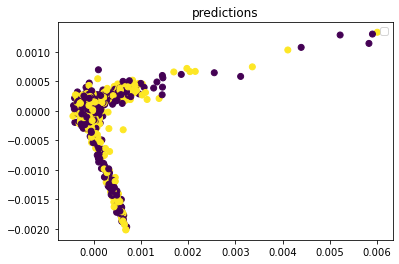

No handles with labels found to put in legend.


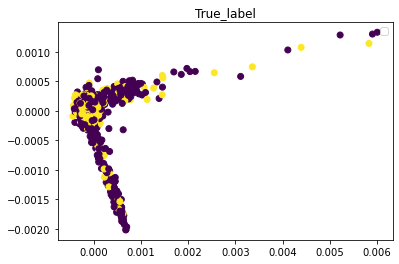

100%|██████████| 2000/2000 [01:32<00:00, 21.71it/s]


Update : 


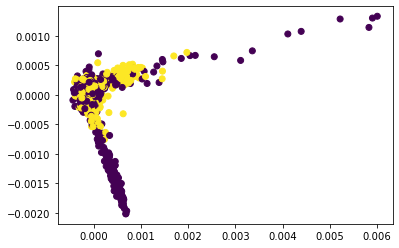

No handles with labels found to put in legend.


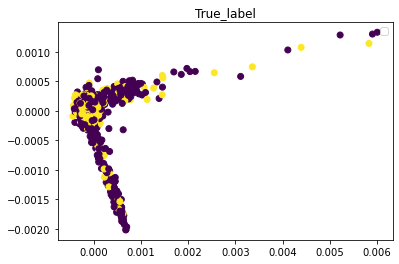

100%|██████████| 2000/2000 [01:37<00:00, 20.45it/s]


Update : 


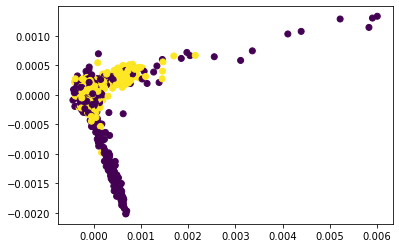

No handles with labels found to put in legend.


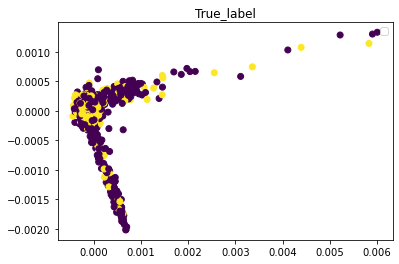

100%|██████████| 2000/2000 [01:26<00:00, 23.23it/s]


Update : 


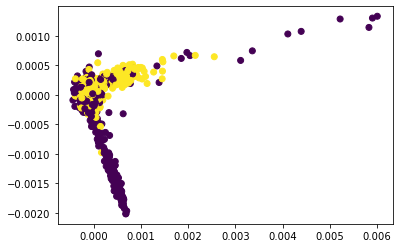

No handles with labels found to put in legend.


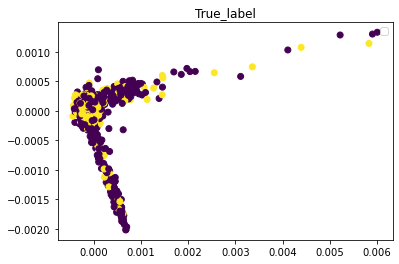

100%|██████████| 2000/2000 [01:31<00:00, 21.94it/s]


Update : 


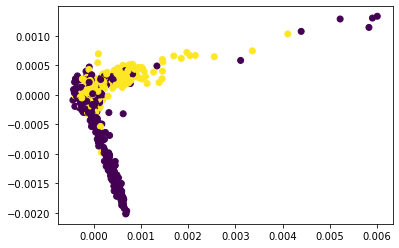

No handles with labels found to put in legend.


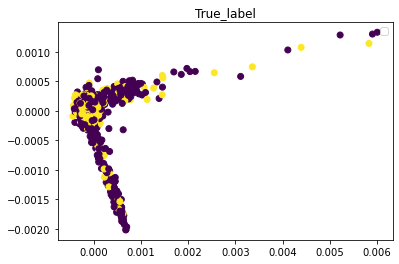

100%|██████████| 2000/2000 [01:31<00:00, 21.74it/s]


Update : 


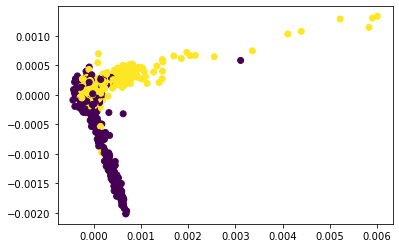

No handles with labels found to put in legend.


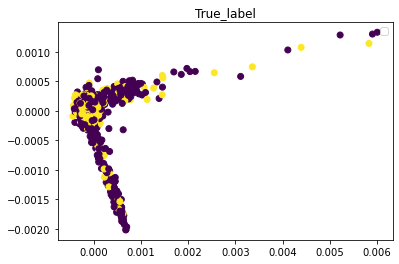

In [38]:
pred = spectrum_KKM.fit(list_K_train_spectrum_6[0], K= 2, z = X_train_100[0], true_label= Y_train[0], Niter_max = 5)

In [48]:
print(np.abs((Y_train[0]-np.abs(pred))).mean())

0.4765


In [31]:
list_K_train_spectrum_6[0].shape

(2000, 2000)